In [ ]:
import os
import numpy as np
import librosa

# Loading the dataset
# The dataset is structured with folders
data_dir = "D:\projects\Momenta project\dataset_ted"
img_height = 128
img_width = 128
sample_rate = 16000  # Standard for speech data
n_mels = 128  # Number of Mel frequency bins

In [ ]:
from scipy.ndimage import zoom
def audio_to_spectrogram(audio_path, label):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sample_rate)
    # Generate Mel-spectrogram for the audio using librosa
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
    # Resize to fixed size for input to the model (128x128)
    mel_spec_db = zoom(mel_spec_db, (img_height / mel_spec_db.shape[0], img_width / mel_spec_db.shape[1]))
    return mel_spec_db, label

In [ ]:
X, y = [], []
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith(".wav"):
            file_path = os.path.join(root, filename)
            # Assign label based on filename 
            if filename == "real.wav":
                label = 0  # Genuine audio
            else:
                label = 1  # Deepfake audio (openvoice, seamless, valle, whisperSpeech, yourTTS)
            spec, lbl = audio_to_spectrogram(file_path, label)
            X.append(spec)
            y.append(lbl)

In [ ]:
from tensorflow.keras.utils import to_categorical
X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=2)      # One-hot encoding for binary classification

In [ ]:
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize spectrograms to the range [0, 1]
X_train = X_train / np.max(np.abs(X_train))
X_test = X_test / np.max(np.abs(X_test))

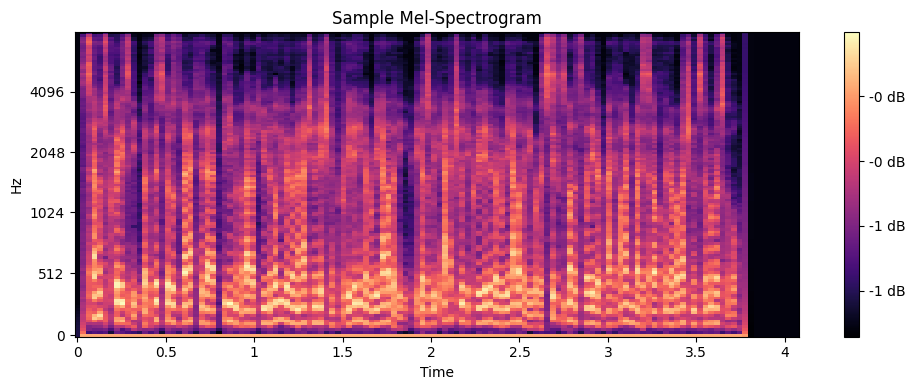

Training data shape: (3824, 128, 128), Labels shape: (3824, 2)
Test data shape: (956, 128, 128), Labels shape: (956, 2)


In [12]:
import matplotlib.pyplot as plt

# Save or visualize a sample (optional)
plt.figure(figsize=(10, 4))
librosa.display.specshow(X_train[0], sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Sample Mel-Spectrogram")
plt.tight_layout()
plt.show()

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [14]:
model = models.Sequential([
        layers.Input(shape=(img_height, img_width, 1)),  # Add channel dimension
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 classes: real vs. fake
    ])

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Train model 
history = model.fit(X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1)


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.8039 - loss: 0.5032 - val_accuracy: 0.8107 - val_loss: 0.4309
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.8198 - loss: 0.4115 - val_accuracy: 0.8902 - val_loss: 0.2915
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.8870 - loss: 0.2564 - val_accuracy: 0.9425 - val_loss: 0.1473
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 26s 217ms/step - accuracy: 0.9437 - loss: 0.1398 - val_accuracy: 0.9697 - val_loss: 0.0786
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 0.9765 - loss: 0.0766 - val_accuracy: 0.9634 - val_loss: 0.0912
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 0.9771 - loss: 0.0646 - val_accuracy: 0.9686 - val_loss: 0.0780
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.9853 - loss: 0.0459 - val_accuracy: 0.9749 - val_loss: 0.0733
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 0.9855 - loss: 0

In [16]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9940 - loss: 0.0188
Test accuracy: 0.9937


In [17]:
model.save("ted_lium_cnn_model.h5")

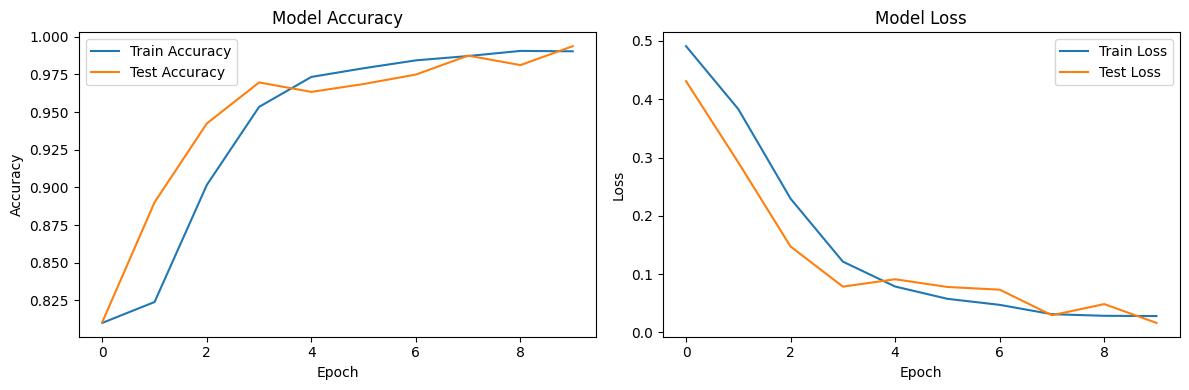

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()